In [61]:

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import ReLU, Add, GlobalAveragePooling2D, Dense,MaxPooling2D
import numpy as np
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [65]:
dataset_path = "E:\MV-coursework\Augmented_Car_Logo_Dataset+"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 使用20%的数据作为验证集

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # 训练集

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # 验证集

tset_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  


Found 448 images belonging to 32 classes.
Found 96 images belonging to 32 classes.
Found 96 images belonging to 32 classes.


In [4]:
x_train, y_train = train_generator.next()
x_test, y_test = validation_generator.next()

In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

# 通道注意力机制
def channel_attention(input_feature):
    channel_axis = -1  
    channels = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channels // 8,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channels,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pooling = GlobalAveragePooling2D()(input_feature)    
    avg_pooling = Reshape((1, 1, channels))(avg_pooling)
    avg_pooling = shared_layer_one(avg_pooling)
    avg_pooling = shared_layer_two(avg_pooling)

    max_pooling = GlobalMaxPooling2D()(input_feature)
    max_pooling = Reshape((1, 1, channels))(max_pooling)
    max_pooling = shared_layer_one(max_pooling)
    max_pooling = shared_layer_two(max_pooling)

    x = Add()([avg_pooling, max_pooling])
    x = Activation('sigmoid')(x)

    return multiply([input_feature, x])
#

# 空间注意力机制
def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    
    x = Conv2D(filters=1,
               kernel_size=kernel_size,
               strides=1, 
               padding='same',
               activation='sigmoid',
               kernel_initializer='he_normal',
               use_bias=False)(concat)                   

    return multiply([input_feature, x])


In [6]:
from keras.layers import Add

def residual_block(input_tensor, filters, kernel_size=3, stride=1):
    # 主路径
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)

    # 残差路径
    shortcut = input_tensor
    if stride != 1 or input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    # 将残差路径的输出加到主路径上
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


In [7]:
def depthwise_separable_conv(x, filters):
    # 深度卷积
    x = DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 逐点卷积
    x = Conv2D(filters, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


In [8]:
input_1 = Input(shape=(100, 100, 3))
x = Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu')(input_1)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
# 添加残差模块
x = residual_block(x, 96)

x = Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

# 使用深度可分离卷积层
#x = depthwise_separable_conv(x, 384)

x = Conv2D(384, kernel_size=(1, 3), activation='relu', padding='same')(x)
x = channel_attention(x)
x = spatial_attention(x)
x = Conv2D(256, kernel_size=(3, 1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
y = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
y = GlobalAveragePooling2D()(y)
output1 = Dense(32, activation='softmax')(y)

# model_1 = Model(inputs=input_1, outputs=model_1_output)
model_1_test = Model(inputs=input_1, outputs=output1)

In [ ]:
model_1_test.summary()

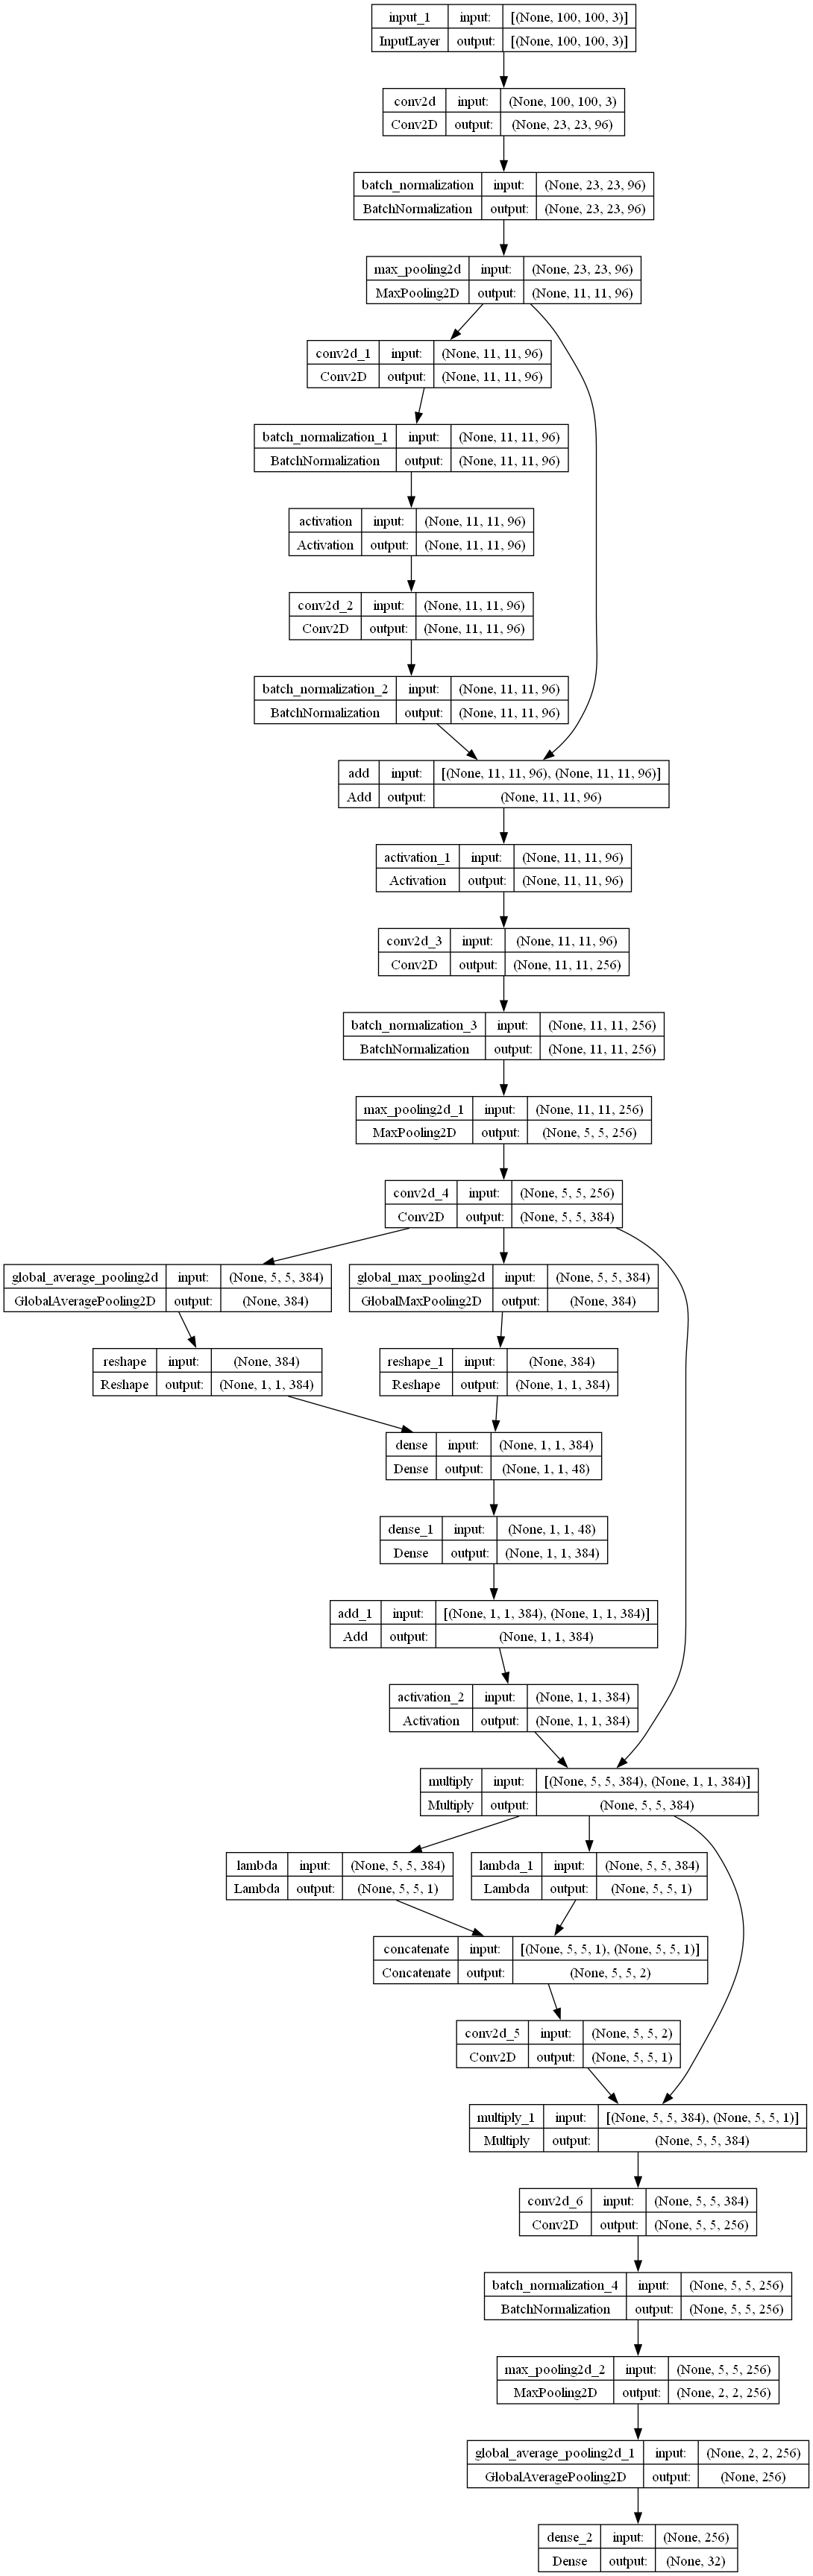

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model_1_test, to_file='ensemble_model_plot.png', show_shapes=True, show_layer_names=True) 

In [11]:
def inception_module(input_tensor, filter_channels):
   
    branch_1x1 = Conv2D(filter_channels, (1,1), padding='same', activation='relu')(input_tensor)

    # 1x7 conv branch
    # First 1x1 conv
    branch_1x7 = Conv2D(filter_channels, (1,1), padding='same', activation='relu')(input_tensor)
    # 1x7 conv
    branch_1x7 = Conv2D(filter_channels, (1,7), padding='same', activation='relu')(branch_1x7)
    # 7x1 conv
    branch_1x7 = Conv2D(filter_channels, (7,1), padding='same', activation='relu')(branch_1x7)

    # 7x1 followed by 1x7 conv branch (double)
    # First 1x1 conv
    branch_7x1_double = Conv2D(filter_channels, (1,1), padding='same', activation='relu')(input_tensor)
    # First 7x1 conv
    branch_7x1_double = Conv2D(filter_channels, (7,1), padding='same', activation='relu')(branch_7x1_double)
    # Second 1x7 conv
    branch_7x1_double = Conv2D(filter_channels, (1,7), padding='same', activation='relu')(branch_7x1_double)
    # Second 7x1 conv
    branch_7x1_double = Conv2D(filter_channels, (7,1), padding='same', activation='relu')(branch_7x1_double)

    # Concatenate all the branches
  
    output=Concatenate(axis=-1)([branch_1x1, branch_1x7, branch_7x1_double])

    return output

In [81]:
# Model 2
input_2 = Input(shape=(100, 100, 3))

x = Conv2D(64, (7,7), activation='relu')(input_2)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (1,1), activation='relu')(x)
x = BatchNormalization()(x)

# 添加通道注意力和空间注意力机制
x = inception_module(x, 64)
x = channel_attention(x)
x = spatial_attention(x)
x = MaxPooling2D(2,2)(x)

x = inception_module(x, 64)
x = MaxPooling2D(2,2)(x)

x = inception_module(x, 64)
x = MaxPooling2D(2,2)(x)

x = inception_module(x, 64)
x = MaxPooling2D(2,2)(x)

x = inception_module(x, 64)
x = MaxPooling2D(2,2)(x)
#x = inception_module(x, 64)
x= GlobalAveragePooling2D()(x)
model_2_output=  Dense(32, activation='softmax')(x)

model_2 = Model(inputs=input_2, outputs=model_2_output)

In [38]:
model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_183 (Conv2D)            (None, 94, 94, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 47, 47, 64)  0           ['conv2d_183[0][0]']             
 )                                                                                                
                                                                                            

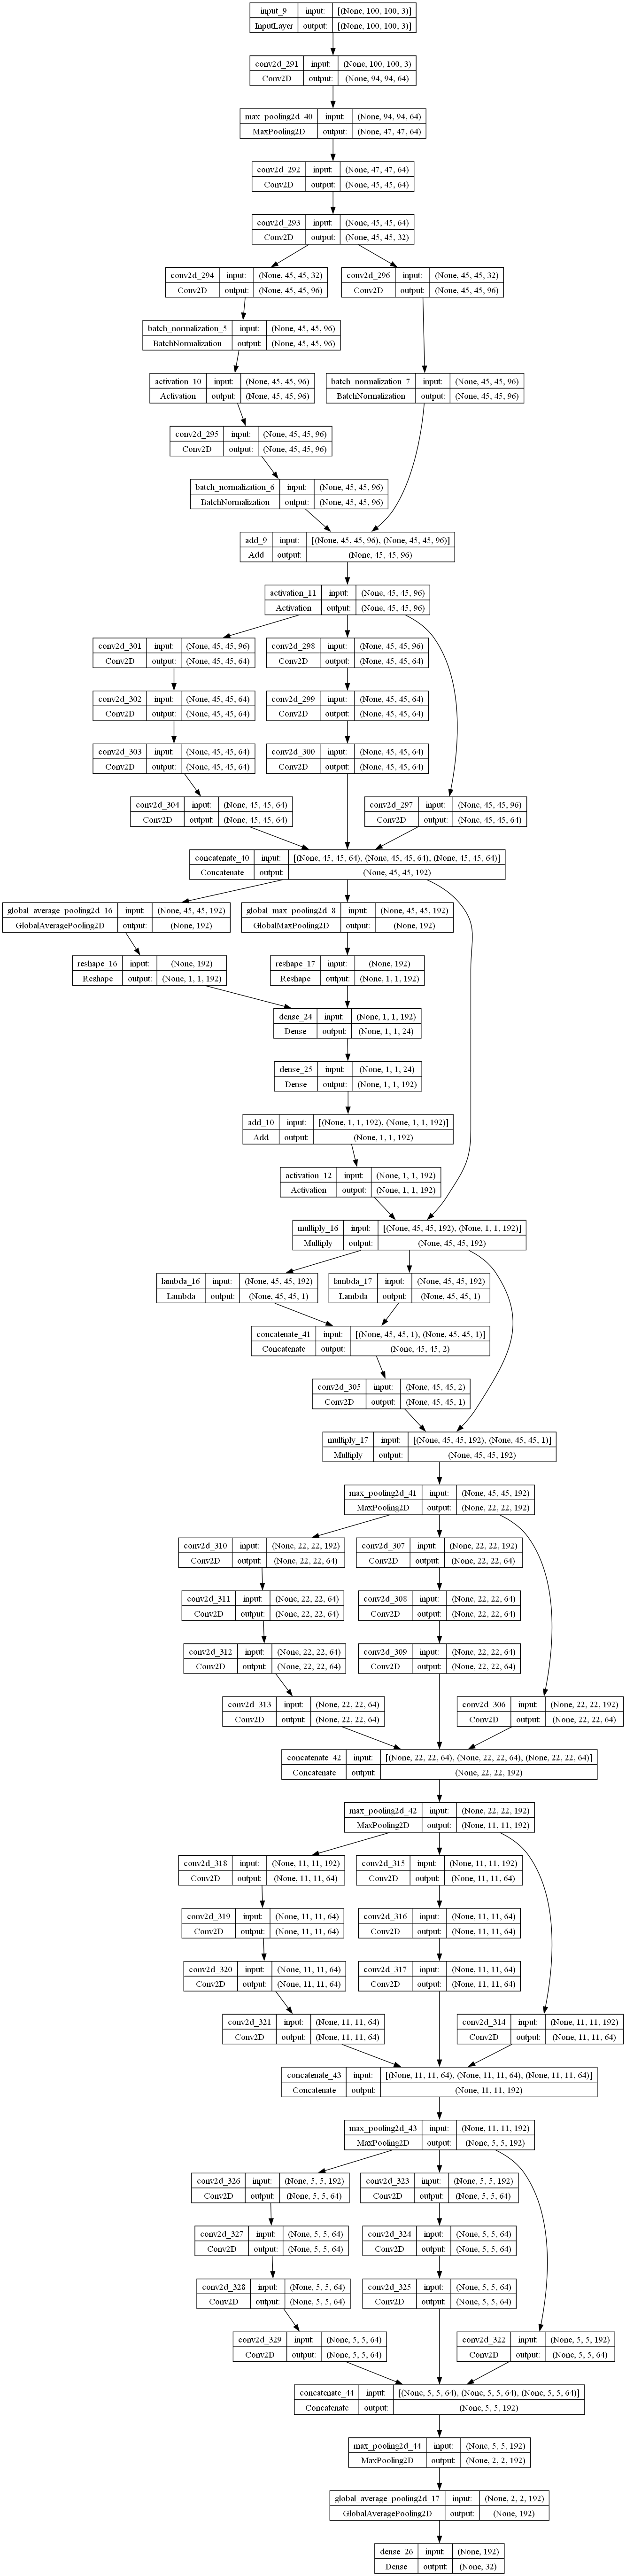

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='ensemble_model_plot.png', show_shapes=True, show_layer_names=True) 

In [82]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
history = model_2.fit(
     train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50
)

Epoch 1/50
14/14 [==============================] - 6s 166ms/step - loss: 3.4697 - accuracy: 0.0290 - val_loss: 3.4658 - val_accuracy: 0.0312
Epoch 2/50
14/14 [==============================] - 2s 113ms/step - loss: 3.2794 - accuracy: 0.1116 - val_loss: 3.4643 - val_accuracy: 0.0417
Epoch 3/50
14/14 [==============================] - 2s 112ms/step - loss: 1.8659 - accuracy: 0.5580 - val_loss: 3.4357 - val_accuracy: 0.0417
Epoch 4/50
14/14 [==============================] - 2s 112ms/step - loss: 0.7970 - accuracy: 0.7902 - val_loss: 3.1158 - val_accuracy: 0.3125
Epoch 5/50
14/14 [==============================] - 2s 115ms/step - loss: 0.5103 - accuracy: 0.8728 - val_loss: 2.5448 - val_accuracy: 0.4167
Epoch 6/50
14/14 [==============================] - 2s 111ms/step - loss: 0.3463 - accuracy: 0.9040 - val_loss: 2.9185 - val_accuracy: 0.3125
Epoch 7/50
14/14 [==============================] - 2s 113ms/step - loss: 0.4480 - accuracy: 0.9196 - val_loss: 2.4442 - val_accuracy: 0.4792
Epoch 

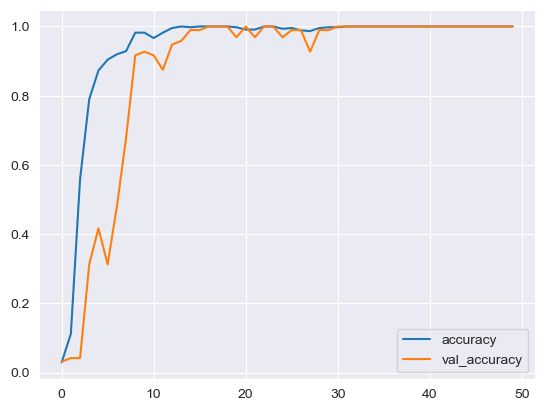

In [84]:
# Plotting Accuracy and Loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

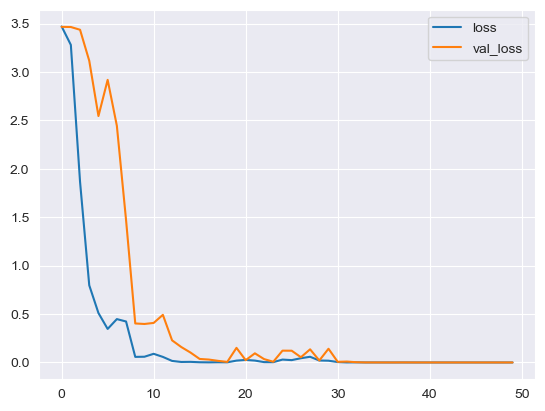

In [85]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [86]:
loss, accurancy = model_2.evaluate(tset_generator)

3/3 [==============================] - 1s 62ms/step - loss: 3.8476e-05 - accuracy: 1.0000


In [87]:
print("loss:", loss)
print("accurancy:", accurancy)

loss: 3.84762097382918e-05
accurancy: 1.0
